In [1]:
from run_sim import run_sim
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
# set up dataframe for collecting event data
mtd_stats, attack_stats = run_sim()

Target Node is:  81


Adversary: Start SCAN_HOST at 0.0s.
Adversary: Processed SCAN_HOST at 5.0s.
Adversary: Start ENUM_HOST at 5.0s.
Adversary: Processed ENUM_HOST at 7.0s.
Adversary: Start SCAN_PORT at 7.0s.
Adversary: Processed SCAN_PORT at 17.0s.
Adversary: Start EXPLOIT_VULN at 17.0s.
MTD: serviceDiversity triggered 30.7s
MTD: serviceDiversity deployed in the network at 30.7s.
Adversary: Processed EXPLOIT_VULN at 47.2s.
Adversary: Start BRUTE_FORCE at 47.2s.
MTD: serviceDiversity triggered 61.2s
MTD: serviceDiversity suspended at 61.2s due to resource occupation
Adversary: Processed BRUTE_FORCE at 67.2s.
Adversary: Start ENUM_HOST at 67.2s.
Adversary: Processed ENUM_HOST at 69.2s.
Adversary: Start SCAN_PORT at 69.2s.
MTD: serviceDiversity finished in 40.6s at 71.3s.
MTD: Interrupted SCAN_PORT at 71.3s!
Adversary: Restarting with SCAN_PORT at 73.3s!
Adversary: Start SCAN_PORT at 73.3s.
Adversary: Processed SCAN_PORT at 83.3s.
Adversary: Start EXPLOIT_VULN at 83.3s.
MTD: serviceDiversity triggered 91.3s


In [3]:
print(mtd_stats.dict())
mtd_operation_record = pd.DataFrame(mtd_stats.mtd_operation_record)

mtd_operation_record

{'Total suspended MTD': 171, 'Total triggered MTD': 600, 'Total executed MTD': 427, 'Total attack interrupted': 336}


,name,start_time,finish_time,duration
0,serviceDiversity,30.687852,71.263679,40.575827
1,serviceDiversity,91.287683,132.485659,41.197976
2,osdiversity,151.825015,182.606337,30.781323
3,CompleteTopologyShuffle,181.998860,252.921657,70.922797
4,HostTopologyShuffle,273.138177,313.737551,40.599375
...,...,...,...,...
422,osdiversity,18046.237118,18076.313395,30.076277
423,CompleteTopologyShuffle,18076.306048,18146.472121,70.166073
424,PortShuffle,18106.538253,18148.814366,42.276113
425,PortShuffle,18167.202761,18209.554051,42.351290


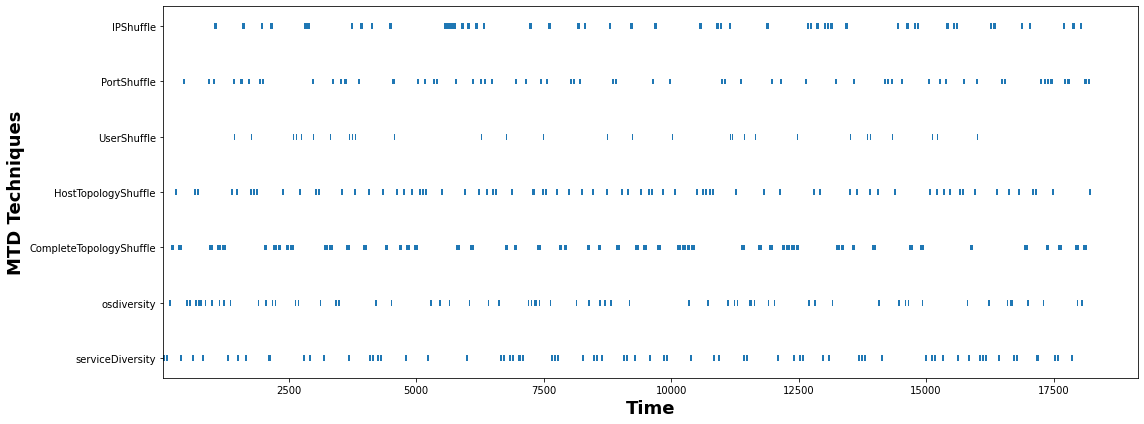

In [4]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.barh(mtd_operation_record['name'], mtd_operation_record['duration'], left=mtd_operation_record['start_time'], height=0.1)

plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('MTD Techniques', weight='bold', fontsize=18)
fig.tight_layout()
plt.show()

In [5]:
attack_operation_record = pd.DataFrame(attack_stats.attack_operation_record)
attack_operation_record

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
0,SCAN_HOST,0.000000,5.000000,5.000000,-1,0,0,0,,[],,
1,ENUM_HOST,5.000000,7.000000,2.000000,-1,0,0,0,,[],,
2,SCAN_PORT,7.000000,17.000000,10.000000,0,1,0,0,,[],,
3,EXPLOIT_VULN,17.000000,47.198080,30.198080,0,1,0,0,,[],,
4,BRUTE_FORCE,47.198080,67.198080,20.000000,0,1,4,0,,[],,
...,...,...,...,...,...,...,...,...,...,...,...,...
2145,SCAN_PORT,18246.964708,18256.964708,10.000000,19,2,745,199,,[],,
2146,EXPLOIT_VULN,18256.964708,18287.069384,30.104676,19,2,745,199,19,[],,
2147,SCAN_NEIGHBOR,18287.069384,18292.069384,5.000000,19,2,745,200,,[],,
2148,ENUM_HOST,18292.069384,18294.069384,2.000000,19,2,745,200,,[],,


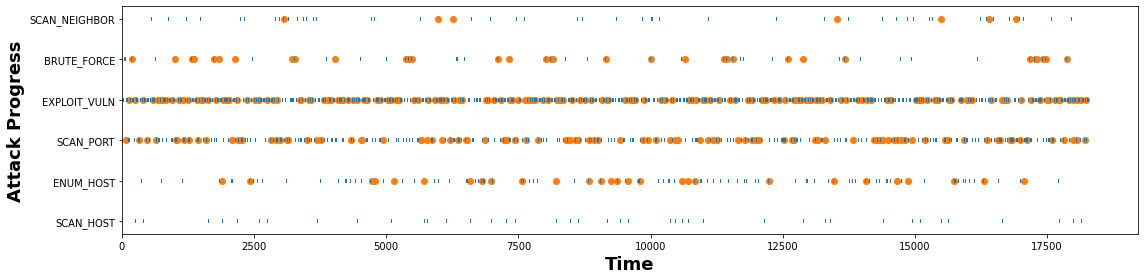

In [16]:
fig2, ax2 = plt.subplots(1, figsize=(16, 4))
ax2.barh(attack_operation_record['name'], attack_operation_record['duration'], left=attack_operation_record['start_time'], height=0.1)
interrupted_record = attack_operation_record[attack_operation_record['interrupted_by'] != '']
ax2.scatter( interrupted_record['finish_time'], interrupted_record['name'])
plt.xlabel('Time',  weight='bold', fontsize=18)
plt.ylabel('Attack Progress', weight='bold', fontsize=18)
fig2.tight_layout()
plt.show()

In [7]:
attack_operation_record[(attack_operation_record['name'] == 'SCAN_PORT') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
94,SCAN_PORT,1024.166419,1034.166419,10.0,28,1,175,9,28,"[Stafani, Lianna]",,
131,SCAN_PORT,1420.792266,1430.792266,10.0,27,3,201,12,27,"[Marieann, Teena, Sandy]",,
295,SCAN_PORT,2997.085841,3007.085841,10.0,51,1,348,27,51,"[Myrah, Angy]",,
313,SCAN_PORT,3139.700155,3149.700155,10.0,44,4,350,30,44,[Hertha],,
402,SCAN_PORT,3955.786787,3965.786787,10.0,50,3,405,37,50,"[Kevyn, Vonnie, Tarra]",,
414,SCAN_PORT,4037.498254,4047.498254,10.0,80,1,405,38,80,"[Edithe, Clerissa]",,
502,SCAN_PORT,4709.252564,4719.252564,10.0,95,1,446,44,95,[],,
706,SCAN_PORT,6502.086638,6512.086638,10.0,91,3,567,60,91,"[Elisha, Datha]",,
725,SCAN_PORT,6600.161128,6610.161128,10.0,76,1,567,62,76,"[Eimile, Xenia]",,
731,SCAN_PORT,6623.161128,6633.161128,10.0,65,1,567,63,65,[],,


In [8]:
attack_operation_record[(attack_operation_record['name'] == 'EXPLOIT_VULN') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by
8,EXPLOIT_VULN,83.263679,113.564887,30.301208,1,1,4,0,1,"[Bethina, Geralda, Christel, Dolly, Irina]",,
17,EXPLOIT_VULN,194.606337,224.825063,30.218726,22,1,29,1,22,"[Wendi, Althea, Binny, Daune]",,
25,EXPLOIT_VULN,271.921657,302.670434,30.748777,26,1,55,2,26,"[Melodee, Rivy, Nariko, Eadith, Terrie]",,
33,EXPLOIT_VULN,332.737551,363.034790,30.297239,27,2,60,3,27,"[Marcile, Catlaina, Sofie, Muire]",,
41,EXPLOIT_VULN,422.568417,453.590032,31.021615,41,1,85,4,41,"[Lacy, Griselda, Shelbi, Donni]",,
...,...,...,...,...,...,...,...,...,...,...,...,...
2106,EXPLOIT_VULN,17933.166142,17963.260371,30.094229,15,2,745,195,15,[],,
2116,EXPLOIT_VULN,18013.910957,18044.554775,30.643818,16,2,745,196,16,[],,
2127,EXPLOIT_VULN,18088.313395,18118.978447,30.665052,17,2,745,197,17,[],,
2136,EXPLOIT_VULN,18165.472121,18196.585068,31.112947,18,2,745,198,18,[],,


In [9]:
attack_operation_record[(attack_operation_record['name'] == 'BRUTE_FORCE') & (attack_operation_record['compromise_host'] != '')]

,name,start_time,finish_time,duration,current_host,current_host_attempt,cumulative_attempts,cumulative_compromised_hosts,compromise_host,compromise_users,interrupted_in,interrupted_by


In [10]:
if not os.path.exists('data_analysis'):
    os.makedirs(os.path.dirname('data_analysis'))

attack_operation_record.to_csv('data_analysis/attack_operation_record.csv',index=False)
mtd_operation_record.to_csv('data_analysis/mtd_operation_record.csv', index=False)